## PUI2016 HW9: Time series analysis with the MTA turnstile data

#### The goal of this analysis is to find outliers, trends and periodicity in the MTA turnstile data.

#### The dataset used contains weekly data for 600 Manhattan stations for each of the 23 different subway cards. This dataset was organized by Sina Kashuk (srk325(at)nyu.edu) at CUSP.

In [1]:
# Python 2 / 3 comp
from __future__ import print_function
from __future__ import division

# Standard imports to work with timeseries, plotting, etc.
import pylab as pl
import numpy as np
import pandas as pd
import os
import json
import requests
import urllib2
from IPython.display import Image

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)
url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
pl.rcParams.update(data)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Obtain the data for the Analysis (from the fbb55 HW9 Github Repo)
# https://github.com/fedhere/PUI2016_fb55/raw/master/HW9_fb55/MTA_Fare.npy

if not os.path.isfile(os.getenv("PUIDATA") + "/" "MTA_Fare.npy"):
    os.system("curl -O https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW9_fb55/MTA_Fare.npy")
    os.system("mv MTA_Fare.npy " + os.getenv("PUIDATA"))
    print ("file downloaded to PUIDATA directory, you can continue")
else:
    print ("file in place, you can continue")

file downloaded to PUIDATA directory, you can continue


In [150]:
# Load the python data cube

mtarides = np.load(os.getenv("PUIDATA") + "/" "MTA_Fare.npy")
print (mtarides.shape)

# Basic Data Cleanup (Convert to float and replace the -1 with NaN)

mtarides = mtarides.astype(numpy.float, copy = False)
mtarides[mtarides == -1] = np.nan

# Create an array with the redetype
ridetype = ['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud']

# Create a date range for the weeks
rng = pd.date_range('5/21/2010', periods=194, freq='W')

(600, 23, 194)


In [83]:
# now we can use the nan functions that deal with the absence of data

print ("Using nanmean on mtarides: " + str (np.nanmean(mtarides)))
print ("Using regular mean on mtarides: " + str (np.mean(mtarides)))

Using nanmean on mtarides: 2849.41627865
Using regular mean on mtarides: nan


### Analysis 1: Event Detection

#### The first part of the analysis will attempt to identify the most prominent event. This event is defined as a very significant drop (>3-sigma) in all time series.

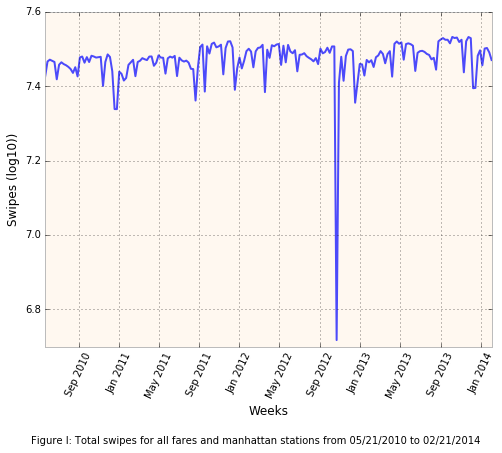

In [84]:
# Sum the timeseries for all stations and fares (we are looking fpr an event that we know is common to all 
# time series)

mtarides_allStations = np.nansum(mtarides, axis = 0)
# print (mtarides_allStations.shape)

mtarides_allStationsAndFares = np.nansum(mtarides_allStations, axis = 0)
# print (mtarides_allStationsAndFares.shape)

pl.figure(figsize=(8, 6))
pl.xlabel("Weeks")
pl.ylabel("Swipes (log10))") 

# Plot sum of all rides (using log10 on the y axis to improve visibility)
pl.plot(rng, np.log10(mtarides_allStationsAndFares),'b', alpha=0.7)
pl.xticks(rotation='65')
pl.legend(loc='upper left')

figtext(0.1,-.1,"Figure I: Total swipes for all fares and manhattan stations from 05/21/2010 to 02/21/2014")

In [85]:
# Identifying the event: We will take the mean and standard deviation 
# and find points that deviate from the mean by more than 3 standard deviations
# bellow code snippet from https://github.com/fedhere/UInotebooks/blob/master/timeseries/FDNYdeaths.ipynb

print ("mean swipes by week {:.2f}".format(np.nanmean(mtarides_allStationsAndFares)))
print ("stdev swipes by week {:.2f}".format(np.nanstd(mtarides_allStationsAndFares)))

thresholds = [np.nanmean(mtarides_allStationsAndFares) + 3 * np.nanstd(mtarides_allStationsAndFares), 
              np.nanmean(mtarides_allStationsAndFares) - 3 * np.nanstd(mtarides_allStationsAndFares)]

print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))
print ("earliest datapoint", min(rng))

mean swipes by week 29781349.87
stdev swipes by week 2983960.42
3-sigma thresholds 38733231.14 20829468.61
earliest datapoint 2010-05-23 00:00:00


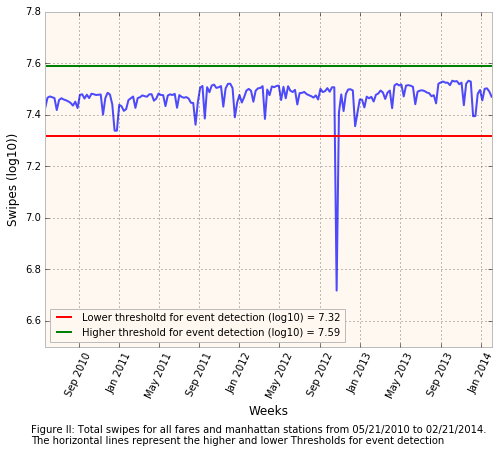

In [86]:
pl.figure(figsize=(8, 6))
pl.xlabel("Weeks")
pl.ylabel("Swipes (log10))") 
pl.ylim(6.5,7.8)

# Plot sum of all rides (using log10 on the y axis to improve visibility)
pl.plot(rng, np.log10(mtarides_allStationsAndFares),'b', alpha=0.7)
pl.xticks(rotation='65')

# Plot the lower Thereshold for the event detection
pl.plot((min(rng), max(rng)),(np.log10(thresholds[1]),np.log10(thresholds[1])), color='r',
       label='Lower thresholtd for event detection (log10) = %.2f' % np.log10(thresholds[1]))

# Plot the higher Thereshold for the event detection
pl.plot((min(rng), max(rng)),(np.log10(thresholds[0]),np.log10(thresholds[0])), color='g',
        label='Higher threshold for event detection (log10) = %.2f' % np.log10(thresholds[0]))

figtext(0.1,-.1,"Figure II: Total swipes for all fares and manhattan stations from 05/21/2010 to 02/21/2014. \n"
 "The horizontal lines represent the higher and lower Thresholds for event detection")
pl.legend(loc='lower left')

In [87]:
# Get the date for the event and try to explain what it might be related to
print (rng[np.where(mtarides_allStationsAndFares < 20829468.61)])

DatetimeIndex(['2012-10-21'], dtype='datetime64[ns]', freq=None)


#### A simple web search for MTA october 2012 gives a hint on the drop of swipes that we see on the week of 2012-10-21:
#### On Sunday, October 28, 2012 - 07:00 there was an MTA System-wide Shutdown in preparation for Hurcane Sandy.

#### http://www.mta.info/news/2012/10/28/mta-system-wide-shutdown

### Analysis 2: Trend Analysis

#### The second part of the analysis will attempt to identify trends on the ridership types. In particular, those ridership types that  have either steadily increased or decreased in popularity. We will try to quantify those changes by calculating the ratio of ussage between the first 10 and last 10 weeks.

In [88]:
# Sum the time series for all stations (we are going to be evaluating the time series for each of the
# different types of fares)

mtarides_allStations = np.nansum(mtarides, axis = 0)
# print (mtarides_allStations.shape)

#for n in range(0,len(mtarides_allStations)):
#    print ((np.min(mtarides_allStations[n]))>0)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:37: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


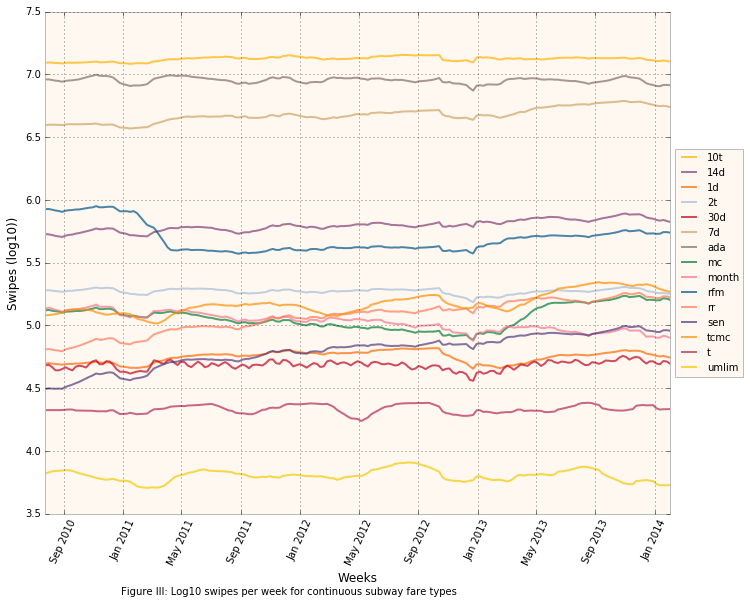

In [89]:
# Visually explore the data (plot all the relevant time series

#print (np.nanmin(np.log10(pd.stats.moments.rolling_mean(mtarides_allStations[0], 10))))

# Color sequence from FBB stationary notebook sample
# https://github.com/fedhere/UInotebooks/blob/master/timeseries/stationarity.ipynb
# Will create a function to plot iterating through the color sequence for the different fares

kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    # The following don't work well for people with defective color vision
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

seqlen = len(kelly_colors_hex)

def plot_rtype(range, rtype, color):
    '''Function to plot the time series cycling through color sequence'''
    pl.plot(range, np.log10(pd.stats.moments.rolling_mean(mtarides_allStations[rtype], 10)), color=color, 
           alpha = .7, label = ridetype[rtype])
    
pl.figure(figsize=(14, 9))
pl.xlabel("Weeks")
pl.ylabel("Swipes (log10))") 
ax = plt.subplot(111)
    
curr_col = 0

# Create a dictionary to store the begnings and ends of the time series
# The key will be the code for the fare type and the values a tuple
# With the position on the original array and the ration value
# E.G. {'2t': (3, 0.933803359955935)}

fareSeriesRatios = {}

for n in range(0,len(mtarides_allStations)):
    
    # Check if the time series is continuous (doesnt have weeks with 0 rides)
    # This seems to us a good criteria to rule out upfront things that wont
    # Steaditly increase or decrease
    
    if ((np.min(mtarides_allStations[n])) > 0):
        
    # Plot sum of all rides (using log10 on the y axis to improve visibility)
        #if ((np.nanmin(np.log10(pd.stats.moments.rolling_mean(mtarides_allStations[n], 10))) > 4) &
        #((np.nanmax(np.log10(pd.stats.moments.rolling_mean(mtarides_allStations[n], 10))) < 6))):
        #pl.plot(rng, np.log10(pd.stats.moments.rolling_mean(mtarides_allStations[n], 10)),
        #alpha=0.7, )
        
        plot_rtype(rng, n, kelly_colors_hex[curr_col])
        curr_col = (curr_col + 1)%seqlen
    
        # Sum all the rides for the begining (first ten weeks)
        # and the end of the series (last ten weeks)
        
        begningSeries = mtarides_allStations[n,:10].sum()
        endSeries = mtarides_allStations[n,-10:].sum()
        seriesRatio = endSeries/begningSeries
        fareSeriesRatios[ridetype[n]] = (n,seriesRatio)

pl.xticks(rotation='65')

# Shrink current axis by 20%
# So I can put a legend to the right of the current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

figtext(0.2,-.00001,"Figure III: Log10 swipes per week for continuous subway fare types")

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


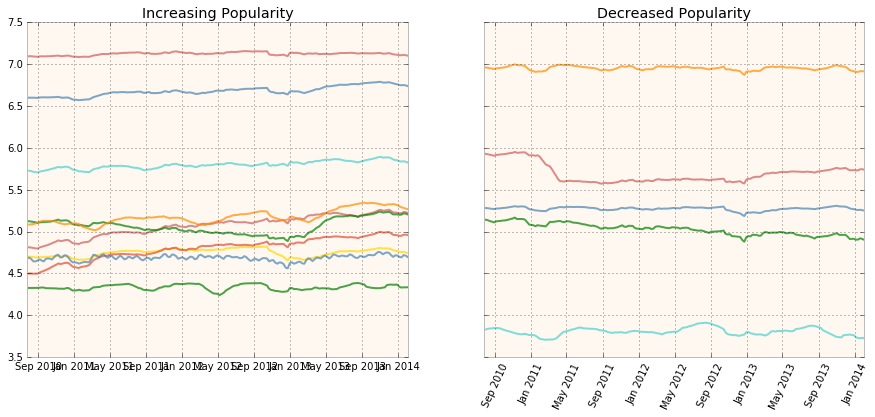

In [147]:
# If a ridership type popularity has increased, the ratio will be > 1 (ended with more rides that started)
# if it decreased, it will be the oposite. Lets plot them side by side

f, (ax1, ax2) = pl.subplots(1, 2, sharey=True, figsize=(15,6))
pl.xticks(rotation='65')

ax1.set_title('Increasing Popularity')
ax2.set_title('Decreased Popularity')

for key, value in fareSeriesRatios.iteritems():
    if (fareSeriesRatios[key][1] > 1):
        ax1.plot(rng, np.log10(pd.stats.moments.rolling_mean(mtarides_allStations[fareSeriesRatios[key][0]], 10)), 
                 alpha = .7, label = key)
    else:
        ax2.plot(rng, np.log10(pd.stats.moments.rolling_mean(mtarides_allStations[fareSeriesRatios[key][0]], 10)), 
                 alpha = .7, label = key)

The fare type with the steepest upware trend is sen, this fare went from an average 
of 31208.6 swipes per week during the first 10 weeks to an average of 90798.2 during the last ten weeks


The fare type with the steepest downard trend is month, this fare went from an average 
of 137296.4 swipes per week during the first 10 weeks to an average of 79456.5 during the last ten weeks


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


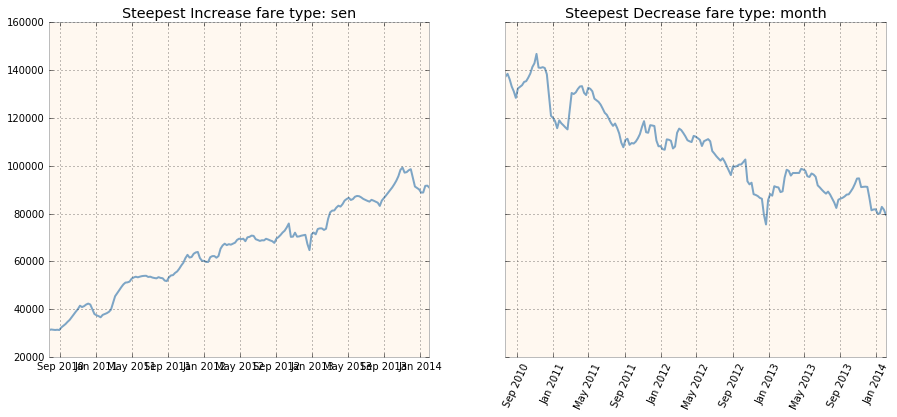

In [149]:
# Getting the min and max values from the fareSeriesRations dictionary
# This will represent the fares with the steepes upward and dowward trends
# Snippet to Get max and min from a dic from stack overflow (http://stackoverflow.com/a/3282871)

downFare =  min(fareSeriesRatios.items(), key=lambda x: x[1][1])
upFare =  max(fareSeriesRatios.items(), key=lambda x: x[1][1])

print ("The fare type with the steepest upware trend is " + upFare[0] + ", this fare went from an average " +
       '\n' + "of " + str(np.average(mtarides_allStations[ridetype.index(upFare[0])][:10])) + " swipes " +
       "per week during the first 10 weeks to an average of " 
       + str(np.average(mtarides_allStations[ridetype.index(upFare[0])][-10:])) + " during the last ten weeks")

print ('\n')

print ("The fare type with the steepest downard trend is " + downFare[0] + ", this fare went from an average " +
       '\n' + "of " + str(np.average(mtarides_allStations[ridetype.index(downFare[0])][:10])) + " swipes " +
       "per week during the first 10 weeks to an average of " 
       + str(np.average(mtarides_allStations[ridetype.index(downFare[0])][-10:])) + " during the last ten weeks")


# Plot both side by side, using absolut values (not log10) with rolling mean for 10 weeks

f, (ax1, ax2) = pl.subplots(1, 2, sharey=True,figsize=(15,6))
pl.xticks(rotation='65')

ax1.set_title('Steepest Increase fare type: ' + upFare[0])
ax2.set_title('Steepest Decrease fare type: ' + downFare[0])

ax1.plot(rng, pd.stats.moments.rolling_mean(mtarides_allStations[fareSeriesRatios['sen'][0]],10)
         , alpha = .7, label = 'sen')

ax2.plot(rng, pd.stats.moments.rolling_mean(mtarides_allStations[fareSeriesRatios['month'][0]],10)
        , alpha = .7, label = 'month')


### Analysis 3: Trend Analysis

#### The second part of the analysis will attempt to identify the four stations that show the most prominent periodic trend on an anual period. We will attempt to explain the reason for this periodic peak

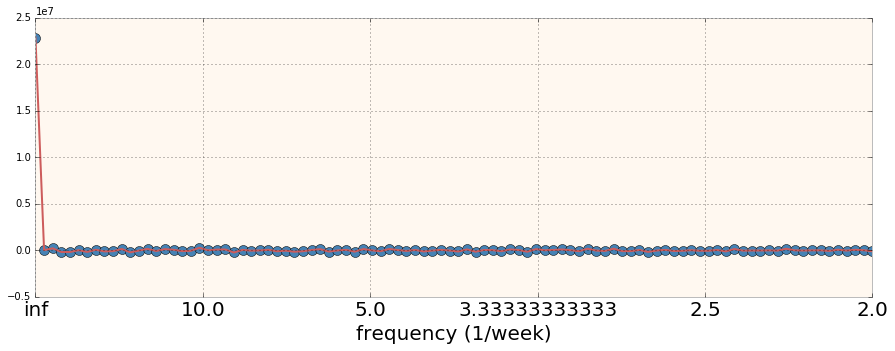

In [171]:
# Will collapse the fare types dimension of the cube (we care about stations here!)
mtarides_allStations = np.nansum(mtarides, axis=1)

N = len(mtarides_allStations[1])

f = np.fft.rfft(mtarides_allStations[200])
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.plot(np.fft.rfftfreq(N, 1.0), (f), 'o', ms=10)
ax.plot(np.fft.rfftfreq(N, 1.0), (f), '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("frequency (1/week)", fontsize=20)